<a href="https://colab.research.google.com/github/Edo745/GAN-PyTorch/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import time

#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
#manualSeed=8527 #remove to make random
print("Random Seed: ", manualSeed)

random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  1273


In [ ]:
%%capture
#loading the dataset
dataset = dset.MNIST(root='GAN/data', download=True,
                       transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),#-1,1
                       ]))


dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

#checking the availability of cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'


#Generative Adversarial Network

##  Generator and Discriminator Networks

Let us define two network a Generator G(z): $ℝ^Z -> ℝ^{N\times N} $  where z is the dimensionality of the input noise and N is the output image resolution.

Tip: use unbiased Transposed Convolutions to go from
$z \times 1\times 1$ to $1 \times N \times N$

Remember that in pytorch it is conventional to have: $batch\_size \times n\_channels \times width \times height$ and that the extra dimension accounting for batch size is automatically created by the data loader.

## Convolutions

A 2D convolution with no padding ($p=0$) and no stride ($s=1$ for a kernel of size $(k,k)$ has an output feature map of size $o = i - k + 1$

If we add padding $p$ to the output we get $o = i - k + 1 + 2p$

Finally, if we use a stride > 1 we get
$o = (i - k + 2p)/s + 1$

## Transposed Convolutions

A transposed convolution works symmetrically with respect to a convolution therefore it is implemented in a way that $o_T = i$ and $i_T = o$

So for a Conv2D, solving for i we get $so = i - k + 2p + s$ and $i = (s-1)o + k - 2p$

Finally for a ConvTranspose2D we have

$o_T = (s-1)i_T + k - 2p + 1$


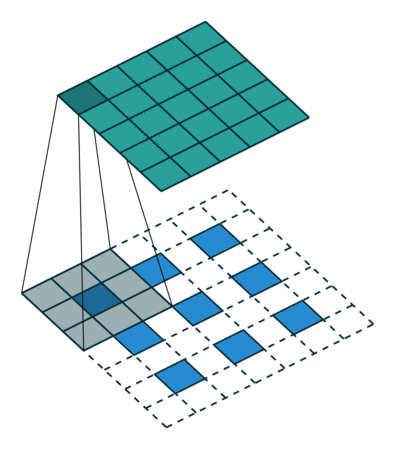









*Recommendations*

**Generator:**

1.   Start from 512 filters and halve at each layer
2.   Go from 1x1 -> 4x4 and then double at each layer
3.   Adjust the final transposed convolution to get a $1\times 28 \times 28$
4.   Do not use biases

Docs: https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

**Discriminator:**
1.   Start from 64 filters and double at each layer
2.   Try to reach 1x1 resolution to avoid FC layers
3.   Use appropriate activation
4.   Again no biases




### Generator Architecture
<div align="center">
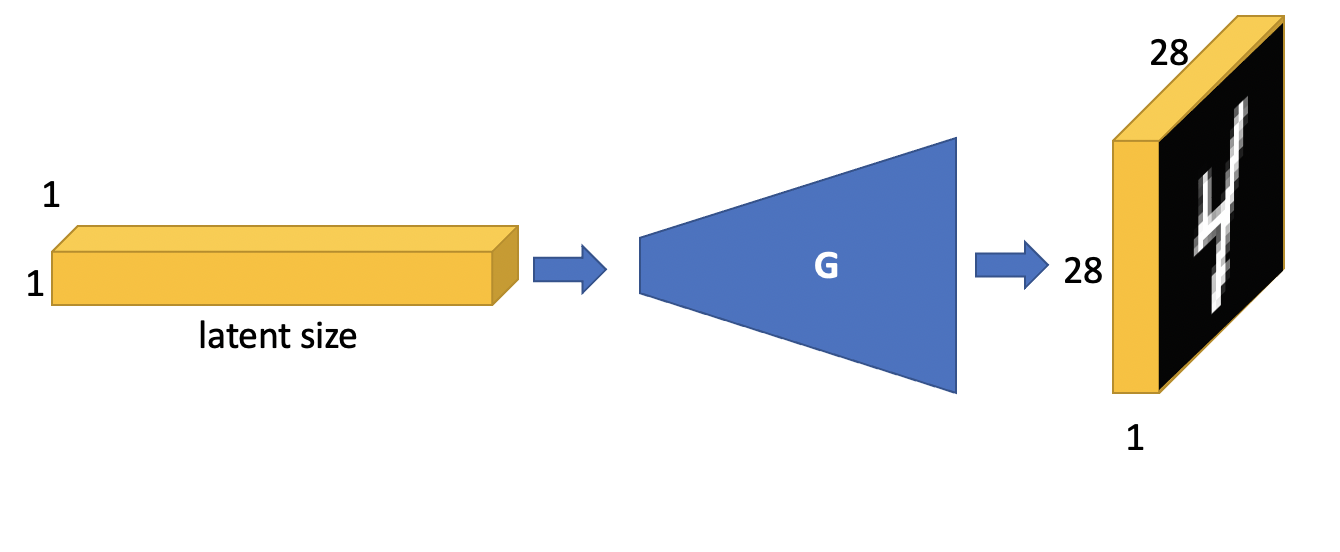</div>

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=1): # nz: input noise dimension, ngf: number of generator filters, nc: number of generated image channels.
        super(Generator, self).__init__()
        # Set bias to False for convolution layers
        bias = False

        # Define convolution transpose layers
        # Parameters: in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0
        self.convt1 = nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=bias)
        self.convt2 = nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=bias)
        self.convt3 = nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=bias)
        self.convt4 = nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=bias)
        self.convt5 = nn.ConvTranspose2d(ngf, nc, 1, 1, 2, bias=bias)

    def forward(self, input):
        # Define activation function (ReLU)
        act = torch.nn.functional.relu

        # Apply convolution transpose layers with activation functions
        x = act(self.convt1(input))
        x = act(self.convt2(x))
        x = act(self.convt3(x))
        x = act(self.convt4(x))

        # Apply the final convolution layer without activation function
        x = self.convt5(x)

        # Apply hyperbolic tangent activation function to normalize output between -1 and 1
        x = torch.tanh(x)

        return x


### Discriminator Architecture

<div align="center">
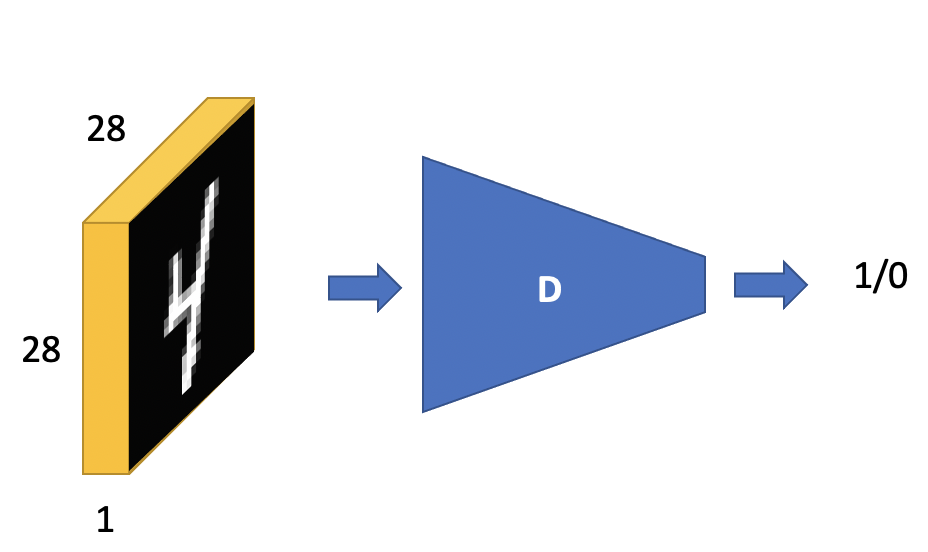 </div>

In [ ]:
class Discriminator(nn.Module):
    # nc: number of channels of the input image, ndf: number of discriminator filters
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()

        # Set bias to False for convolution layers
        bias = False

        # Define convolution layers
        # Parameters: in_channels, out_channels, kernel_size, stride=1, padding=0
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=bias)
        self.conv2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=bias)
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=bias)
        self.conv4 = nn.Conv2d(ndf*4, 1, 4, 2, 1, bias=bias)

    def forward(self, input):
        # Define activation function (ReLU)
        act = torch.nn.functional.relu

        # Apply convolution layers with activation functions
        x = act(self.conv1(input))
        x = act(self.conv2(x))
        x = act(self.conv3(x))

        # Apply the final convolution layer without activation function
        x = self.conv4(x)

        # Apply sigmoid activation function to normalize output between 0 and 1
        output = torch.sigmoid(x)

        # Reshape output
        return output.view(-1, 1).squeeze(1)



##Model Initialization
Instantiate the two networks and move to GPU

Generator(
  (convt1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (convt2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convt3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convt4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convt5): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
)
Fake image shape: torch.Size([1, 1, 28, 28])


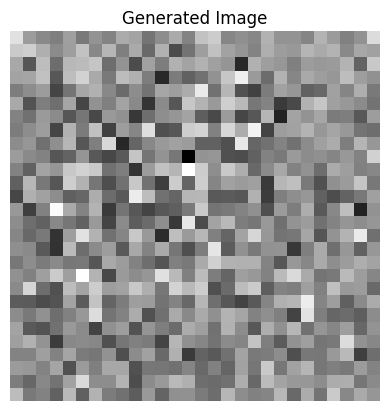

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator prediction: tensor([0.5000], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [ ]:
# Generator
nz=100
netG = Generator().to(device) ; print(netG)
noise =  torch.randn(1, nz, 1, 1).to(device)
img = netG(noise) ;  print(f"Fake image shape: {img.shape}")

img_np = img.squeeze().cpu().detach().numpy()
plt.imshow(img_np, cmap='gray')
plt.title('Generated Image')
plt.axis('off')
plt.show()

# Discriminator
netD = Discriminator().to(device) ; print(netD)
pred = netD(img) ; print(f"Discriminator prediction: {pred}")

## Data sanity check

Let's check if G output is compatible with D input with a  run on uninitialized networks



In [ ]:
for i, (data, labels) in enumerate(dataloader, 0):
    print(data.shape)
    noise =  torch.randn(1, nz, 1, 1, device=device)
#get some random noise for G
    fake = netG(noise) #get G(z)
    print(f'fake shape: {fake.shape}')
    #print input/output shape and range
    break

torch.Size([64, 1, 28, 28])
fake shape: torch.Size([1, 1, 28, 28])


## Training

Now we train our GAN. For each batch there two steps:


1.   First we train the Discriminator by assembling a batch of real || fake examples with labels (1... || 0....) and using Binary Cross Entropy Loss.
Remember to detach the fake samples from the model to avoid looping computation graphs!
2.   Then we update the Generator by minimizing $-\log ( D(G(z))$ over fake samples

Tip: step 1 can also be two separate gradient updates, one for real samples from the dataloader and one for fake samples from noise



In [ ]:
criterion = nn.BCELoss()

# setup optimizers
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

nepochs = 5

loss_g, loss_d, d_fake, d_real = [],[],[],[]

print("\nTRAINING\n")

for epoch in range(nepochs):
    for i, (data, labels) in enumerate(dataloader, 0):
        t_start = time.time()

        #------------------------------------------------------------
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        #------------------------------------------------------------

        optimizerD.zero_grad()

        # real samples
        real = data.to(device)
        batch_size = real.size(0) # 64
        label_r = torch.full((batch_size,), real_label, device=device).float() # 64 ones tensor

        # fake samples
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label_f = torch.full((batch_size,), fake_label, device=device).float() # 64 zeros tensor

        # create the batch
        batch = torch.cat((real, fake.detach())) # 128 size tensor containing 64 real images and 64 fake images
        labels =  torch.cat((label_r, label_f)) # 128 labels for the 64+64 real and fake images

        # Discriminator prediction
        output = netD(batch) # 128 probabilities

        # Binary Cross Entropy Loss
        errD = criterion(output, labels)
        errD.backward()

        # Mean response of D on real samples (to print, it has to increase)
        D_x = output[0:batch_size].mean().item()

        # Mean response of D on fake samples (to print, it has to decrease)
        D_G_z1 = output[batch_size:].mean().item()

        # real_cpu = data[0].to(device)

        # Updating the weights of the Discriminator
        optimizerD.step()

        #----------------------------------------------
        # (2) Update G network: minimize -log(D(G(z)))
        #----------------------------------------------
        optimizerG.zero_grad()

        # D(G(z))
        output = netD(fake)

        # -log (D(G(z)))
        errG = -torch.log(output).mean()
        errG.backward()

        # Mean response of on fake samples after the D update (to print, it has to increase)
        D_G_z2 = output.mean().item()

        # Updating the weights of the Generator
        optimizerG.step()

        # Monitoring boiler plate
        t_end = time.time()
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f %.1f images/s'
                       % (epoch+1, nepochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, batch.shape[0]/(t_end-t_start)))

        if i % 100 == 0:
            # vutils.save_image(real_cpu,'real_samples.png' ,normalize=True)
            fake = netG(fixed_noise)
            loss_g.append(errG.item())
            loss_d.append(errD.item())
            d_real.append(D_x)
            d_fake.append(D_G_z1)
            vutils.save_image(fake.detach(),'fake_samples_epoch_%03d.png' % (epoch), normalize=True)
    os.rmdir('GAN/checkpoints')
    os.makedirs('GAN/checkpoints', exist_ok=True)
    torch.save(netG.state_dict(), f'GAN/checkpoints/netG_epoch_{epoch + 1}.pth')


TRAINING

[1/5][0/938] Loss_D: 0.6630 Loss_G: 0.7200 D(x): 0.4743 D(G(z)): 0.4050 / 0.5029 2785.3 images/s
[1/5][100/938] Loss_D: 0.6537 Loss_G: 0.7424 D(x): 0.5484 D(G(z)): 0.4808 / 0.4888 4921.9 images/s
[1/5][200/938] Loss_D: 0.6369 Loss_G: 1.0328 D(x): 0.5954 D(G(z)): 0.5064 / 0.3724 5781.8 images/s
[1/5][300/938] Loss_D: 0.6792 Loss_G: 0.9523 D(x): 0.5579 D(G(z)): 0.5081 / 0.4084 5738.7 images/s
[1/5][400/938] Loss_D: 0.6994 Loss_G: 0.9993 D(x): 0.5503 D(G(z)): 0.5312 / 0.3826 5430.9 images/s
[1/5][500/938] Loss_D: 0.7177 Loss_G: 1.0287 D(x): 0.4864 D(G(z)): 0.4904 / 0.3674 5581.7 images/s
[1/5][600/938] Loss_D: 0.6667 Loss_G: 0.8225 D(x): 0.5275 D(G(z)): 0.4790 / 0.4508 5326.6 images/s
[1/5][700/938] Loss_D: 0.6780 Loss_G: 0.6962 D(x): 0.5747 D(G(z)): 0.5356 / 0.5054 4017.7 images/s
[1/5][800/938] Loss_D: 0.6851 Loss_G: 0.6758 D(x): 0.4315 D(G(z)): 0.3771 / 0.5203 4036.3 images/s
[1/5][900/938] Loss_D: 0.6729 Loss_G: 0.8213 D(x): 0.6234 D(G(z)): 0.5598 / 0.4522 5454.0 images/s
[

## Data generation

Create a new noise tensor $z$ from a Gaussian $𝓝(0, \textbf{I})$ and then use the Generator to create images out of z.


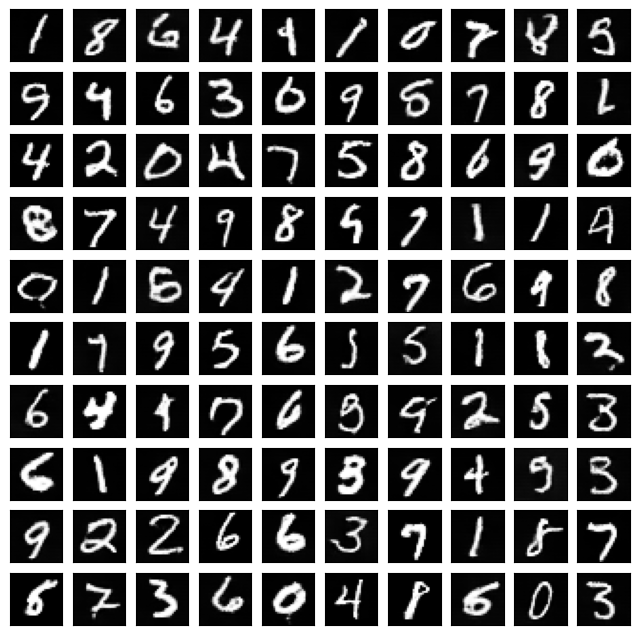

In [ ]:
# I will make a square nxn display of generated images
n=10
batch_size = n**2
latent_size = nz
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake_images = netG(fixed_noise)

# Plot
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = n, n

figure(figsize=(8, 8))

for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)

os.makedirs("GAN/results/", exist_ok=True)
plt.savefig("GAN/results/generated_images.png")
plt.show()

##Analyze plots

Now plot losses and Discriminator value for real and fake examples over learning

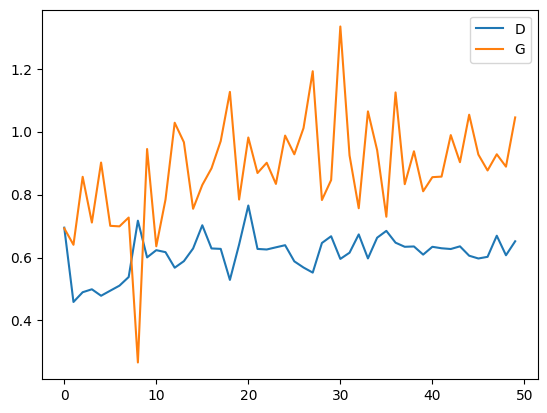

In [ ]:
#Plot the loss
plt.plot(loss_d, label='D')
plt.plot(loss_g, label='G')
plt.legend()

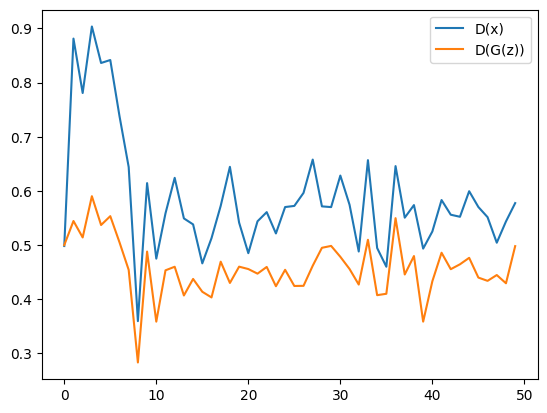

In [ ]:
plt.plot(d_real, label='D(x)')
plt.plot(d_fake, label='D(G(z))')

plt.legend()